<a href="https://colab.research.google.com/github/Adithyanjohnson/vehicle-damage-detection-model-maskrccn/blob/main/feb24FINALcode1maskrccn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu118/torch2.0/index.html
!pip install Pillow==9.5.0
!pip install numpy==1.23.5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path to your dataset
dataset_path = '/content/drive/MyDrive/dataset/CarDD_release/CarDD_release'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.6) to /tmp/pip-install-wegml1fa/detectron2_ef73cdf42f044a73a236f679490fcf0b
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-install-wegml1fa/detectron2_ef73cdf42f044a73a236f679490fcf0b
  Running command git checkout -q d1e04565d3bec8719335b88be9e9b961bf3ec464
  Resolved https://github.com/facebookresearch/detectron2.git to commit d1e04565d3bec8719335b88be9e9b961bf3ec464
  Preparing metadata (setup.py) ... done


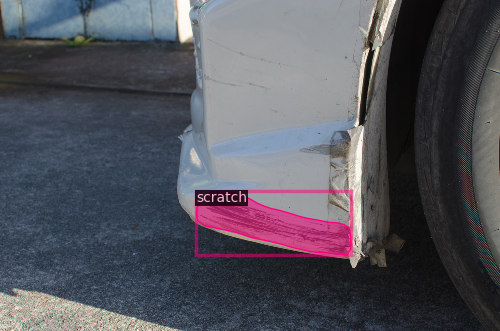

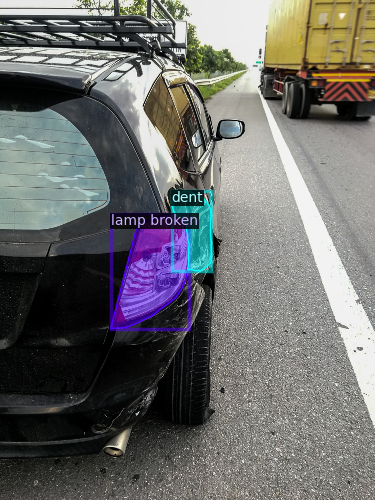

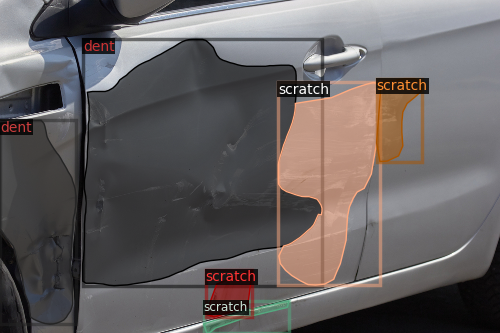

In [ ]:
import os
import numpy as np
import json
# Restart kernel after running the pip install command
!pip install -U 'git+https://github.com/facebookresearch/detectron2.git@v0.6#egg=detectron2'
from detectron2 import model_zoo # Import after installation and kernel restart
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from google.colab.patches import cv2_imshow
import cv2
import random

# Register COCO-format datasets
if "car_dd_train" not in DatasetCatalog:
    register_coco_instances("car_dd_train", {}, f"{dataset_path}/CarDD_COCO/annotations/instances_train2017.json", f"{dataset_path}/CarDD_COCO/train2017")
if "car_dd_val" not in DatasetCatalog:
    register_coco_instances("car_dd_val", {}, f"{dataset_path}/CarDD_COCO/annotations/instances_val2017.json", f"{dataset_path}/CarDD_COCO/val2017")

# Load metadata
car_dd_metadata = MetadataCatalog.get("car_dd_train")
dataset_dicts = DatasetCatalog.get("car_dd_train")

# Visualize random samples
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=car_dd_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])


In [ ]:


# Configure the model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))  #to convert code to fcn  # cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/fcn_R_50.yaml"))
cfg.DATASETS.TRAIN = ("car_dd_train",)
cfg.DATASETS.TEST = ("car_dd_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 500  # Increase for better training  default 500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # Adjust based on your dataset

# Output directory
cfg.OUTPUT_DIR = "/content/output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


In [ ]:
# Train the model
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()






[01/23 05:10:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 161MB/s]
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[01/23 05:10:54 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/23 05:11:13 d2.utils.events]:  eta: 0:04:20  iter: 19  total_loss: 3.102  loss_cls: 1.816  loss_box_reg: 0.5882  loss_mask: 0.6924  loss_rpn_cls: 0.0769  loss_rpn_loc: 0.04305  time: 0.7252  data_time: 0.2991  lr: 9.7405e-05  max_mem: 2672M
[01/23 05:11:26 d2.utils.events]:  eta: 0:04:16  iter: 39  total_loss: 2.089  loss_cls: 0.7834  loss_box_reg: 0.5429  loss_mask: 0.6724  loss_rpn_cls: 0.05887  loss_rpn_loc: 0.02693  time: 0.6741  data_time: 0.2144  lr: 0.00019731  max_mem: 2672M
[01/23 05:11:38 d2.utils.events]:  eta: 0:04:05  iter: 59  total_loss: 2.1  loss_cls: 0.6643  loss_box_reg: 0.6546  loss_mask: 0.6481  loss_rpn_cls: 0.07179  loss_rpn_loc: 0.03881  time: 0.6575  data_time: 0.1474  lr: 0.0002972  max_mem: 2672M
[01/23 05:11:50 d2.utils.events]:  eta: 0:03:48  iter: 79  total_loss: 1.758  loss_cls: 0.5649  loss_box_reg: 0.5201  loss_mask: 0.6169  loss_rpn_cls: 0.03526  loss_rpn_loc: 0.02663  time: 0.6346  data_time: 0.1541  lr: 0.00039711  max_mem: 2672M
[01/23 05:12:01 d

In [ ]:
# Load the saved model for inference
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
predictor = DefaultPredictor(cfg)


/usr/local/lib/python3.11/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

In [ ]:
from detectron2.engine import DefaultPredictor

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)


In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Evaluate on the validation dataset
evaluator = COCOEvaluator("car_dd_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "car_dd_val")
evaluation_results = inference_on_dataset(predictor.model, val_loader, evaluator)
print(evaluation_results)


WARNING [01/23 05:18:36 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[01/23 05:18:36 d2.data.datasets.coco]: Loaded 810 images in COCO format from /content/drive/MyDrive/dataset/CarDD_release/CarDD_release/CarDD_COCO/annotations/instances_val2017.json
[01/23 05:18:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/23 05:18:36 d2.data.common]: Serializing 810 elements to byte tensors and concatenating them all ...
[01/23 05:18:36 d2.data.common]: Serialized dataset takes 1.82 MiB
[01/23 05:18:36 d2.evaluation.evaluator]: Start inference on 810 batches
[01/23 05:18:41 d2.evaluation.evaluator]: Inference done 11/810. Dataloading: 0.1508 s/iter. Inference: 0.1109 s/iter. Eval: 0.0089 s/iter. Total: 0.2706 s/iter. ETA=0:03:36
[01/23 05:18:46 d2.evaluation.evaluator]: Inferen

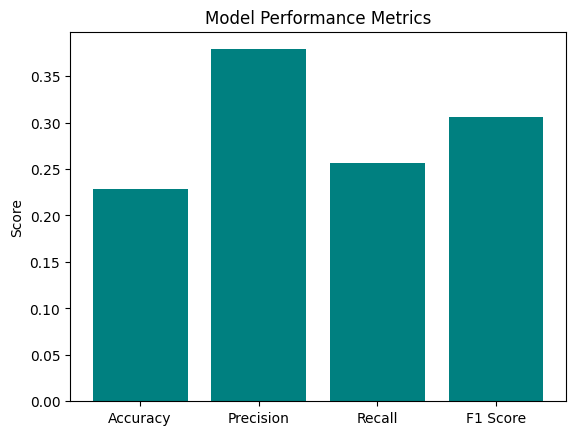

In [ ]:
import matplotlib.pyplot as plt

# Extract relevant metrics
precision = evaluation_results["bbox"]["AP50"] / 100
recall = evaluation_results["bbox"]["AP75"] / 100
accuracy = evaluation_results["bbox"]["AP"] / 100
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Visualization
metrics = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1_score}
plt.bar(metrics.keys(), metrics.values(), color='teal')
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.show()


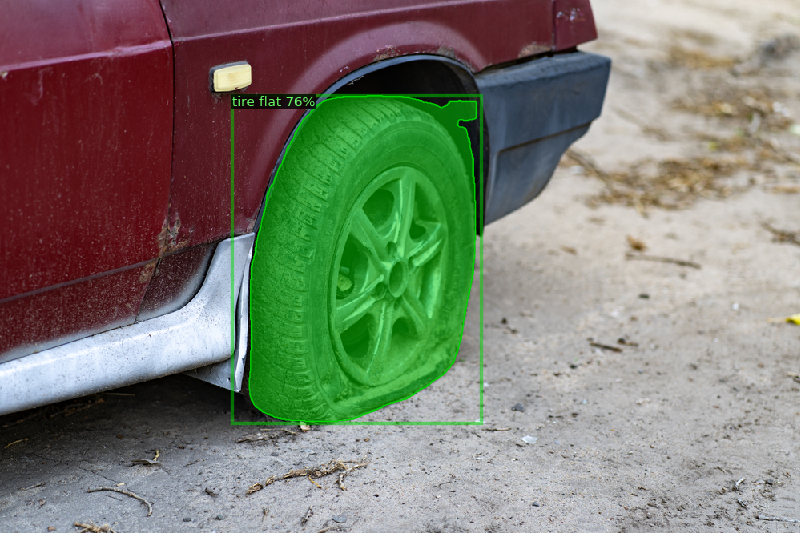

In [ ]:
sample_image_path = f"/content/drive/MyDrive/dataset/CarDD_release/CarDD_release/CarDD_COCO/test2017/000589.jpg"

if os.path.exists(sample_image_path):
    img = cv2.imread(sample_image_path)
    outputs = predictor(img)

    # Visualize predictions
    v = Visualizer(img[:, :, ::-1], metadata=car_dd_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])
else:
    print(f"Error: Image file not found at {sample_image_path}")



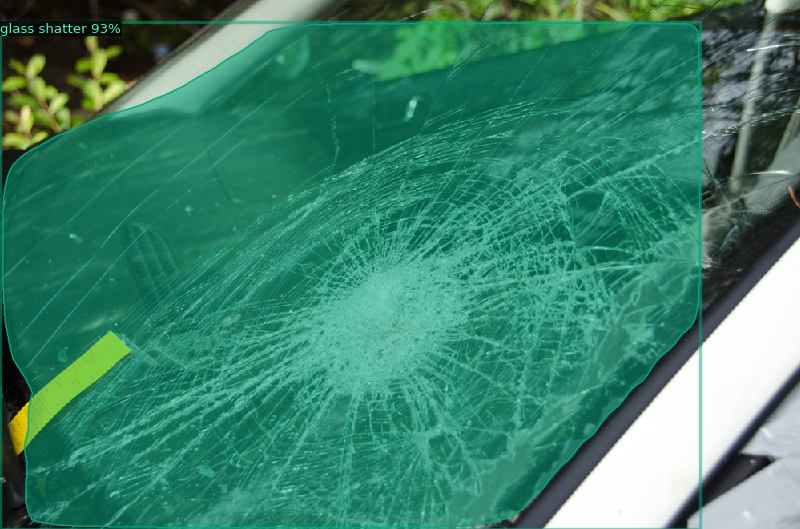

Damage Type: glass shatter, Damage Percentage: 93.0%, Estimated Repair Cost: ₹0


In [ ]:
import cv2
from detectron2.utils.visualizer import Visualizer
from google.colab.patches import cv2_imshow

# Function to estimate repair cost
def estimate_repair_cost(damage_type, damage_percentage):
    # Repair cost ranges (in INR)
    cost_ranges = {
        "scratch": (1000, 3000),
        "crack": (5000, 15000),
        "dent": (3000, 8000),
        "flat_tire": (1500, 5000),
    }

    # Estimate cost based on damage type and percentage
    if damage_type in cost_ranges:
        min_cost, max_cost = cost_ranges[damage_type]
        # The cost will scale with the damage percentage (assuming 100% damage means max cost)
        estimated_cost = min_cost + (max_cost - min_cost) * (damage_percentage / 100)
        return round(estimated_cost, 2)
    return 0

# Path to the image for prediction
sample_image_path = f"/content/drive/MyDrive/dataset/CarDD_release/CarDD_release/CarDD_COCO/test2017/003905.jpg"

if os.path.exists(sample_image_path):
    img = cv2.imread(sample_image_path)
    outputs = predictor(img)

    # Visualize predictions
    v = Visualizer(img[:, :, ::-1], metadata=car_dd_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

    # Extract damage types and their respective areas
    instances = outputs["instances"].to("cpu")
    damage_info = []
    for i in range(len(instances)):
        damage_type = car_dd_metadata.get("thing_classes")[instances.pred_classes[i]]
        damage_percentage = instances.scores[i].item() * 100  # This gives us a rough "confidence" score for damage extent

        # Estimate the repair cost for this damage type and percentage
        repair_cost = estimate_repair_cost(damage_type, damage_percentage)

        # Append damage info to list
        damage_info.append({
            "Damage Type": damage_type,
            "Damage Percentage": round(damage_percentage, 2),
            "Estimated Repair Cost (INR)": repair_cost
        })

    # Output the damage information
    for info in damage_info:
        print(f"Damage Type: {info['Damage Type']}, Damage Percentage: {info['Damage Percentage']}%, Estimated Repair Cost: ₹{info['Estimated Repair Cost (INR)']}")

else:
    print(f"Error: Image file not found at {sample_image_path}")
